In this notebook, we examine image correlation techniques in the framework of an inverse problem. This is based on [Hild and Roux (2006)](https://arxiv.org/ftp/physics/papers/0511/0511122.pdf).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
import numpy as np
from ipywidgets import interact

# Recommended reading 

- Starters: Hild, François, and Stéphane Roux. “Digital Image Correlation: From Displacement Measurement to Identification of Elastic Properties–a Review.” Strain 42, no. 2 (2006): 69–80.
- Yet better: Pan, Bing, Kemao Qian, Huimin Xie, and Anand Asundi. “Two-Dimensional Digital Image Correlation for in-Plane Displacement and Strain Measurement: A Review.” Measurement Science and Technology 20, no. 6 (2009): 062001. doi:10.1088/0957-0233/20/6/062001.
- Found searching for open-source code: https://www.osti.gov/scitech/servlets/purl/1255433
- some more Sandia national labs: https://www.osti.gov/scitech/biblio/1331930-nonlocal-digital-image-correlation
- dice: https://github.com/dicengine/dice

# DIC outline

There are three ways of looking at DIC:

- subset based DIC: correlation averaged over each image patch (classical 80's) (FFT-DIC)
- global DIC: mesh based fields with continuity (Hild & Roux 2006), the continuity is **global**! (Q4-DIC)
- PDE based DIC: more mechanical modelling inside (new approaches, D. Turner, Hild & Roux 2009) since the solution also obeys balance equations


It would be nice to implement all three methods. Because none of them seem too challenging and there's lots of nice stuff inside:

- computing correlation in the Fourier domain
- rough approximation with subpixel interpolation later

# Theoretical background 

Let $f$ and $g$ be two grayscale images. $f$ is the original image and $g$ is its advected form by a displacement field, such that 

$$
g(\vec{x} + \vec{u}) = f(\vec{x})
$$

We can introduce a functional $\phi$ that operates on displacement fields that quantifies the distance between the two advected images:

$$
\phi(\vec{v}) = \iint_\Omega [g(\vec{x} + \vec{v}) - f(\vec{x})]^2 d\Omega
$$

When the displacement field $\vec{v}$ is small, the functional can be written 
$$
\phi(\vec{v}) = \iint_\Omega [g(\vec{x}) - f(\vec{x}) + \vec{\nabla g} \cdot \vec{v}]^2 d\Omega
$$

The gradient of this functional in a direction $\vec{w}$ is then

$$
\frac{\partial \phi}{\partial \vec{w}} = 2 \iint_\Omega [g(\vec{x}) - f(\vec{x}) + \vec{\nabla g} \cdot \vec{v}] \vec{\nabla g} d\Omega
$$

At a minimum of the function $\phi$, the gradient $\frac{\partial \phi}{\partial \vec{w}}$ should be zero (necessary optimality condition). 

If one writes the displacement field  $\vec{v}$ as a linear combination of basis functions  

$$
\vec{v} = \sum_{i=1}^N v_i \vec{\eta_i (\vec{x})}
$$

Then the optimality condition becomes, for each basis function $\forall j \, \vec{\eta_j}$, the following 

$$
\frac{\partial \phi}{\partial \vec{w}} = \vec{0} \Leftrightarrow \sum_{i=1}^N v_i \iint_\Omega (\vec{\nabla g} \cdot \vec{\eta_i}) (\vec{\nabla g} \cdot \vec{\eta_j}) d\Omega = \iint_\Omega [f(\vec{x}) - g(\vec{x})] \vec{\nabla g} \cdot \vec{\eta_j} d\Omega
$$

This means that we can finally write this problem in matrix form:

$$
M V = m
$$

# Solution using finite elements 

Let's solve the above problem using finite elements. For finite elements to work we need:

- nodes
- elements, made of nodes
- connectivity information: a node to element dictionary
- basis functions

## Nodes 

Let's start with the nodes. Each node is defined by its two coordinates, $x$ and $y$ and a label (its Id). As a sample problem for this part, we will work with 12 nodes. 4 along the $x$ direction and 3 along the $y$ direction. We will use the meshgrid machinery to store the information. This means the first axis of coordinate matrices will be the $y$ axis and the second one the $x$ axis. See [this blog post](http://eli.thegreenplace.net/2014/meshgrids-and-disambiguating-rows-and-columns-from-cartesian-coordinates/) for more information about this.

In [2]:
x = np.arange(4)
y = np.arange(3)
X, Y = np.meshgrid(x, y)

In [3]:
X

array([[0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3]])

In [4]:
Y

array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [2, 2, 2, 2]])

The meshgrid above holds the information about the grid elements. Let's build a `nodes` dictionary that maps indexes to $x$ and $y$ coordinates.

In [5]:
nodes = {}
for i in range(X.ravel().size):
    nodes[i] = (X.ravel()[i], Y.ravel()[i])

We can now plot this.

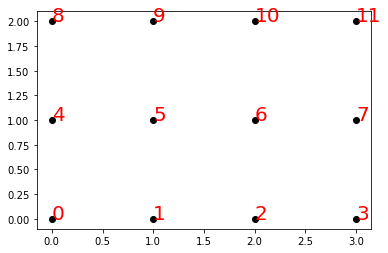

In [6]:
for id in nodes.keys():
    local_x, local_y = nodes[id]
    plt.plot(local_x, local_y, 'ko')
    plt.text(local_x, local_y, str(id), fontdict={'color': 'red', 'fontsize': 20})

## Mesh elements

Let's now build elements: these objects have the knowledge of neighbours with each other.

Here, indexing conventions are important. We will use the following notation *bottom left*, *bottom right*, *top left*, *top right*. Each elements gets an index to the node it is connected to.

In [7]:
class Q1Element:
    """Class that describes a Q1 element with four nodes."""
    def __init__(self, neighbors):
        bottom_left_id, bottom_right_id, top_left_id, top_right_id = neighbors
        self.bottom_left_id = bottom_left_id
        self.bottom_right_id = bottom_right_id
        self.top_left_id = top_left_id
        self.top_right_id = top_right_id
        
    def all_ids(self):
        """Returns all node ids connected in element."""
        return self.bottom_left_id, self.bottom_right_id, self.top_left_id, self.top_right_id

Let's now build our elements.

In [8]:
elements = {}
col_index = 0
row_index = 0
n = 0
while row_index + 1 < y.size:
    bl_id = col_index + row_index * x.size
    br_id = bl_id + 1
    tl_id = bl_id + x.size
    tr_id = tl_id + 1
    elements[n] = Q1Element((bl_id, br_id, tl_id, tr_id))
    n += 1
    col_index += 1
    if col_index + 1 == x.size:
        row_index += 1
        col_index = 0

Let's check we have ended up with 6 elements.

In [9]:
len(elements.keys())

6

In [10]:
elements[5].all_ids()

(6, 7, 10, 11)

## Connectivity: node to elements 

Finally, let's build a node to element dictionary that tells us, for a given node id, which elements it is present in.

In [11]:
node_to_elements = {}
for element_id in elements:
    element = elements[element_id]
    for node_id in element.all_ids():
        if node_id in node_to_elements:
            node_to_elements[node_id].append(element_id)
        else:
            node_to_elements[node_id] = [element_id]

Let's check the output of this dictionary.

In [12]:
node_to_elements

{0: [0],
 1: [0, 1],
 2: [1, 2],
 3: [2],
 4: [0, 3],
 5: [0, 1, 3, 4],
 6: [1, 2, 4, 5],
 7: [2, 5],
 8: [3],
 9: [3, 4],
 10: [4, 5],
 11: [5]}

So we see that everything seems normal here: most nodes are connected to four elements, but some are only connected to two (mesh edges) or just one (corner points).

## Element basis function 

Let's now define our [Q1 finite element basis functions](http://people.inf.ethz.ch/arbenz/FEM16/pdfs/0-19-852868-X.pdf). One element is defined by the value it takes on the four edges of the quadrilateral element.

The element basis functions for $[0, 1] \times [0, 1] $are:

$$
\left\{ 
\begin{array}{lr} 
(1 − x)(1 − y)\\
x(1 − y)\\
xy\\
(1 − x)y
\end{array}
\right.
$$

Let's look at what these element basis functions looks like in 2D and 3D.

In [13]:
def q1_element_func(a, b, c, d):
    """Returns a function valid on the hxh square."""
    bl = lambda x,y: (1 - x)*(1 - y) # bl
    tl = lambda x,y: (1 - x) * y # br
    br = lambda x,y: x*(1 - y) # tl
    tr = lambda x,y: x * y # tr
    return lambda x,y: a * bl(x,y) + b * br(x,y) + c * tl(x,y) + d * tr(x,y)

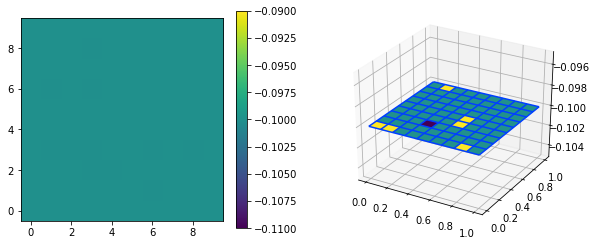

In [14]:
from mpl_toolkits.mplot3d import Axes3D

@interact
def plot_finite_element(a=(-1, 1, 0.1), 
                        b=(-1, 1, 0.1), 
                        c=(-1, 1, 0.1), 
                        d=(-1, 1, 0.1)):
    """Demonstrates the Q1 finite element in an interactive way."""
    num = 10
    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(121)
    
    basis_func = q1_element_func(a, b, c, d)
    x = np.linspace(0, 1, num=num)
    y = np.linspace(0, 1, num=num)
    X, Y = np.meshgrid(x, y)
    mapping = basis_func(X, Y)
    mappable = ax1.imshow(mapping, origin='lower')
    plt.colorbar(mappable)
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X, Y, mapping, cmap='viridis')
    ax2.plot_wireframe(X, Y, mapping)
    

Let's do a plot for each the basis functions.

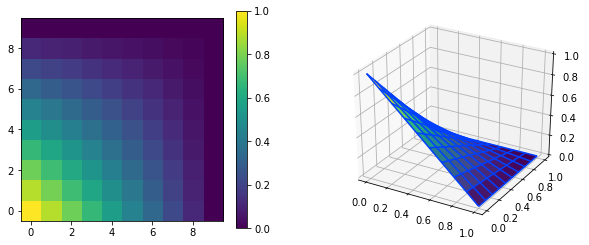

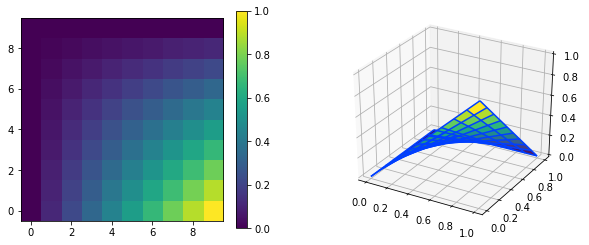

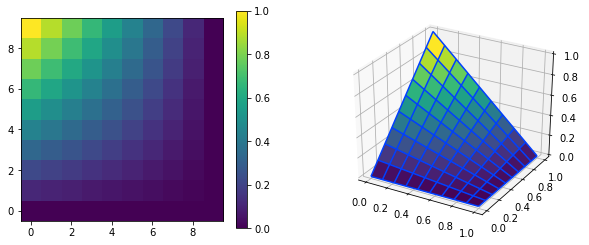

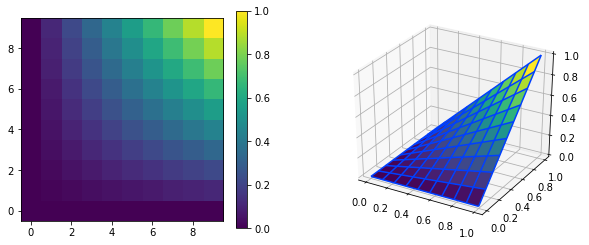

In [15]:
plot_finite_element(1, 0, 0, 0)
plot_finite_element(0, 1, 0, 0)
plot_finite_element(0, 0, 1, 0)
plot_finite_element(0, 0, 0, 1)

## Nodal basis functions

Now that we have the element basis functions, we can use them to build nodal basis functions. How? By noting that each node is connected to several elements and that over each element, the node occupies a different location. Thus by setting the nodal value to 1 and evaluating the element basis functions over the right coordinates we can evaluate these nodal functions everywhere on the mesh.

Let's build a finer grid for evaluating the nodal basis functions.

In [16]:
x_fine = np.linspace(0, 3, num=23, endpoint=False)
y_fine = np.linspace(0, 2, num=13, endpoint=False)
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)

We then need to translate the coordinates to the origin of the local element, its bottom left corner.

In [17]:
nodal_basis_index = 5

In [18]:
local_X = X_fine - nodes[nodal_basis_index][0]
local_Y = Y_fine - nodes[nodal_basis_index][1]

We also build the mask that allows us to restrict the evaluation to a single element.

In [19]:
mask = (local_X >= 0) & (local_X < 1) & (local_Y >= 0) &  (local_Y < 1)

We want to visualize the output of only one corner of the function so we set just one coordinate to 1 and the others to 0 and evaluate the function.

In [20]:
a, b, c, d = 1, 0, 0, 0
basis_func = q1_element_func(a, b, c, d)
mapping = basis_func(local_X, local_Y) * mask

Let's now plot this.

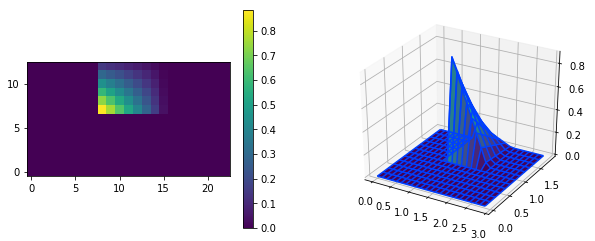

In [21]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
mappable = ax1.imshow(mapping, origin='lower')
plt.colorbar(mappable)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X_fine, Y_fine, mapping, cmap='viridis')
ax2.plot_wireframe(X_fine, Y_fine, mapping)

Let's now loop over this construction to build a full nodal element.

In [22]:
mapping = np.zeros_like(X_fine)
for element_id in node_to_elements[nodal_basis_index]:
    connected_nodes = elements[element_id].all_ids()
    element_origin_node_id = connected_nodes[0]
    local_X = X_fine - nodes[element_origin_node_id][0]
    local_Y = Y_fine - nodes[element_origin_node_id][1]
    mask = (local_X >= 0) & (local_X <= 1) & (local_Y >= 0) &  (local_Y <= 1)
    weights = [0, 0, 0, 0]
    weights[connected_nodes.index(nodal_basis_index)] = 1
    basis_func = q1_element_func(*weights)
    mapping += basis_func(local_X, local_Y) * mask

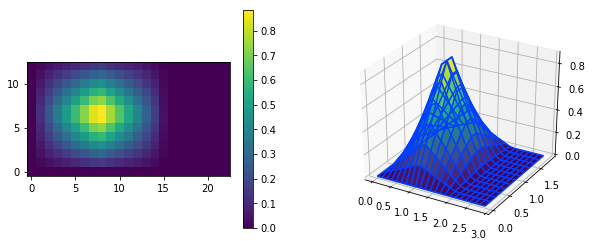

In [23]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
mappable = ax1.imshow(mapping, origin='lower')
plt.colorbar(mappable)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X_fine, Y_fine, mapping, cmap='viridis')
ax2.plot_wireframe(X_fine, Y_fine, mapping)

So now we have our approximation on the fine grid and it looks good. We can do the same for every nodal basis function.

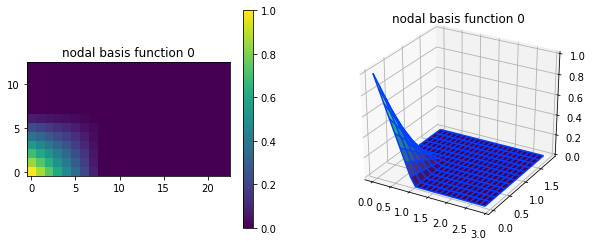

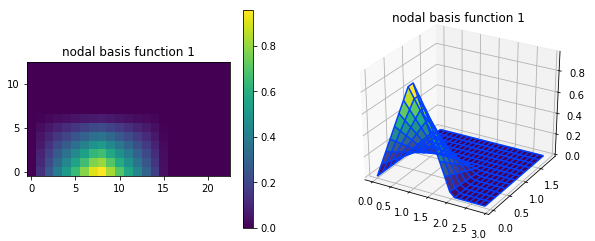

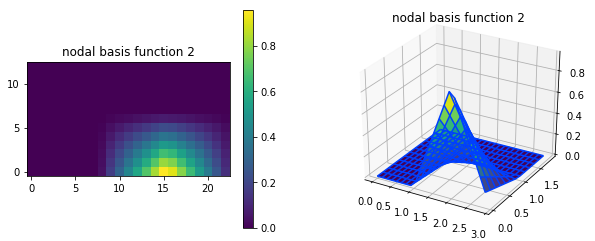

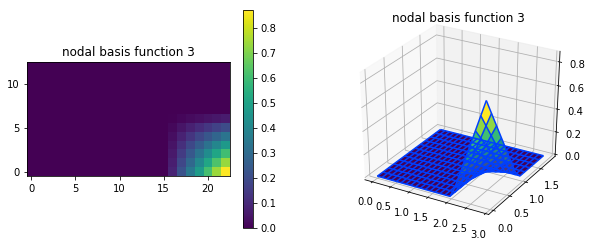

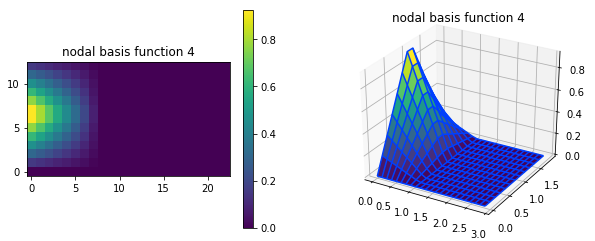

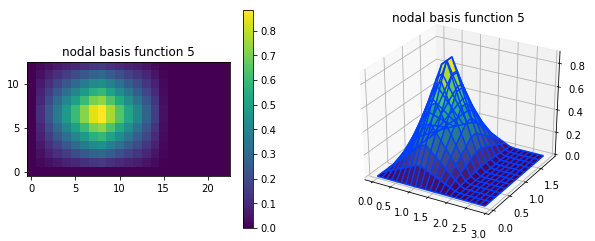

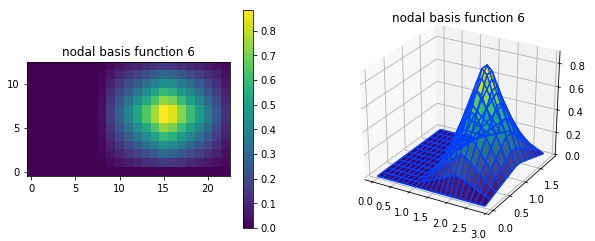

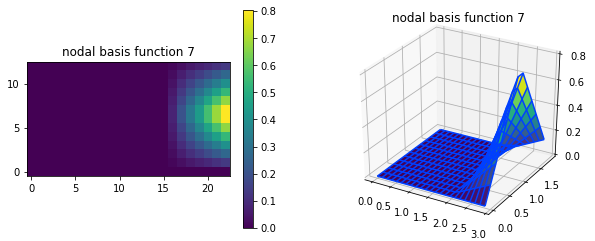

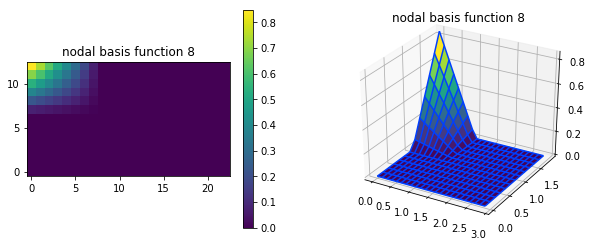

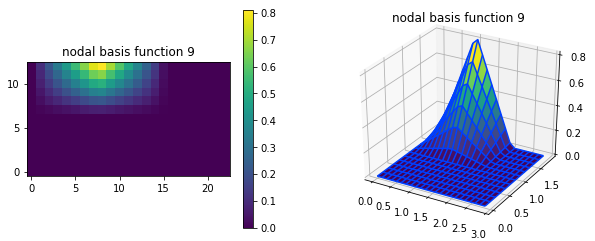

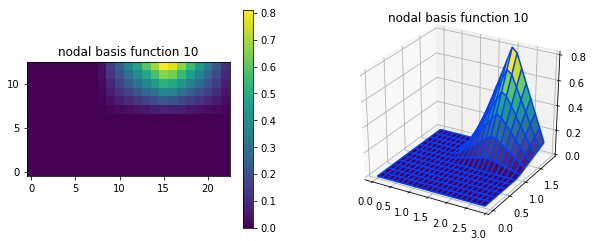

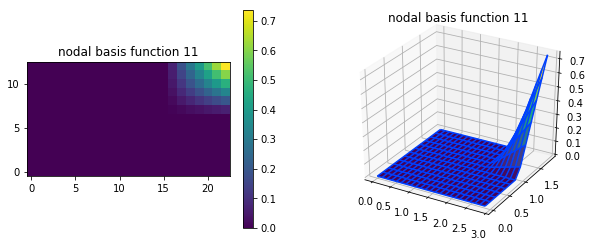

In [24]:
for nodal_basis_index in nodes.keys():

    mapping = np.zeros_like(X_fine)
    for element_id in node_to_elements[nodal_basis_index]:
        connected_nodes = elements[element_id].all_ids()
        element_origin_node_id = connected_nodes[0]
        local_X = X_fine - nodes[element_origin_node_id][0]
        local_Y = Y_fine - nodes[element_origin_node_id][1]
        mask = (local_X >= 0) & (local_X < 1) & (local_Y >= 0) &  (local_Y < 1)
        weights = [0, 0, 0, 0]
        weights[connected_nodes.index(nodal_basis_index)] = 1
        basis_func = q1_element_func(*weights)
        mapping += basis_func(local_X, local_Y) * mask

    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(121)
    ax1.set_title('nodal basis function {}'.format(nodal_basis_index))
    mappable = ax1.imshow(mapping, origin='lower')
    plt.colorbar(mappable)
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title('nodal basis function {}'.format(nodal_basis_index))
    ax2.plot_surface(X_fine, Y_fine, mapping, cmap='viridis')
    ax2.plot_wireframe(X_fine, Y_fine, mapping)

## Representing any field over the grid 

Now that we have come to this point, we can see how our finite element approximation works. By simply injecting nodal values into our grid, we can represent much more complicated fields. Let's apply this principle by injecting random values into the nodes and then build the whole field from these values.

In [25]:
node_values = dict(zip(nodes.keys(), np.random.random(len(nodes.keys()))))
node_values

{0: 0.63930795376081273,
 1: 0.32514631267646099,
 2: 0.29134174589476225,
 3: 0.64549818835289752,
 4: 0.7630635969500128,
 5: 0.44900919792461991,
 6: 0.61503307504498728,
 7: 0.65846399300385861,
 8: 0.62476606881639363,
 9: 0.41078744231295028,
 10: 0.69034977869848291,
 11: 0.021937237619128691}

First, let's represent this using markers.

In [26]:
from matplotlib.colors import Normalize 
from matplotlib.cm import ScalarMappable

In [27]:
normer = Normalize(vmin=min(node_values.values()), vmax=max(node_values.values()))
mapper = ScalarMappable(normer, cmap='viridis')

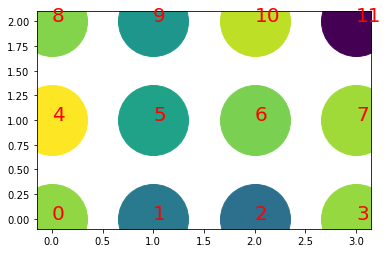

In [28]:
for id, node_value in zip(nodes.keys(), node_values.values()):
    local_x, local_y = nodes[id]
    plt.plot(local_x, local_y, 'o', color=mapper.to_rgba(node_value), ms=70)
    plt.text(local_x, local_y, str(id), fontdict={'color': 'red', 'fontsize': 20})

Let's now loop over all elements and sum the contributions of each node to build a continuous map.

In [29]:
mapping = np.zeros_like(X_fine)
for element_id in elements:
    connected_nodes = elements[element_id].all_ids()
    element_origin_node_id = connected_nodes[0]
    local_X = X_fine - nodes[element_origin_node_id][0]
    local_Y = Y_fine - nodes[element_origin_node_id][1]
    mask = (local_X >= 0) & (local_X < 1) & (local_Y >= 0) &  (local_Y < 1)
    weights = [node_values[i] for i in connected_nodes]
    basis_func = q1_element_func(*weights)
    mapping += basis_func(local_X, local_Y) * mask

And let's plot it: 

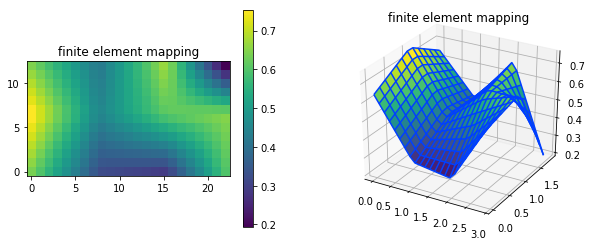

In [30]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax1.set_title('finite element mapping'.format(nodal_basis_index))
mappable = ax1.imshow(mapping, origin='lower')
plt.colorbar(mappable)
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('finite element mapping'.format(nodal_basis_index))
ax2.plot_surface(X_fine, Y_fine, mapping, cmap='viridis')
ax2.plot_wireframe(X_fine, Y_fine, mapping)

This compares well with the above plot that used only colored dots. We see here the advantage of using a mesh instead of just points: we can map to a continuous representation quite easily.

# Assembling the matrix problem 

## Assembling the M matrix 1: sparsity 

Now that we have come this far, we have to compute the terms of the $M$ matrix, as well as the $m$ matrix.

One interesting thing to note is that since the matrix features products between terms that are described as finite elements, we already know that the resulting matrix will be sparse. Let's illustrate this by building the matrix and just setting it to 1 or 0, depending on the connectivity.

In [31]:
M = np.zeros((len(nodes.keys()), len(nodes.keys())))

In [32]:
M.shape

(12, 12)

In [33]:
for current_node_id in nodes.keys():
    for other_node_id in nodes.keys():
        for element_id in elements.keys():
            all_ids = elements[element_id].all_ids()
            if current_node_id in all_ids and other_node_id in all_ids:
                M[current_node_id, other_node_id] = 1

Let's display the matrix.

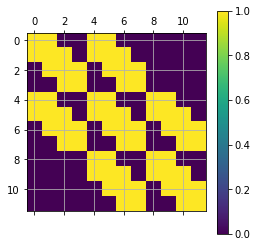

In [34]:
plt.matshow(M)
plt.grid()
plt.colorbar()

How many nodes are connected? 

In [35]:
M.sum() / M.size

0.4861111111111111

## Choosing a test image

Let's now turn to the real thing: we want to assemble the matrix. We can use the loop above but have to take into account that our problem is a vector problem. So we have to separate the $x$ direction unknowns from the $y$ direction unknowns and compute both terms. 

As a first step let's choose a test image and compute the gradient. We will use a sample of a real image with the same shape used in our sample grid until now.

In [36]:
from skimage.data import astronaut
from skimage.color import rgb2gray

In [37]:
image = rgb2gray(astronaut())

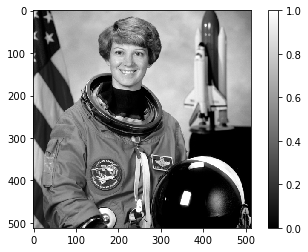

In [38]:
plt.imshow(image, cmap='gray')
plt.colorbar()

Let's now transform this image using a certain displacement field. We will use the [scikit-image swirl operation](http://scikit-image.org/docs/dev/auto_examples/transform/plot_swirl.html#sphx-glr-auto-examples-transform-plot-swirl-py) for this 

In [39]:
from skimage.transform import swirl
deformed_image = swirl(image, rotation=0, strength=1, radius=500)

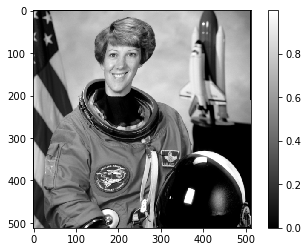

In [40]:
plt.imshow(deformed_image, cmap='gray')
plt.colorbar()

Now, we will use two samples of that image.

In [41]:
def extract_region(image, center, width, height):
    """Extracts a region from an image."""
    r, c = center
    return image[r:r+height, c:c+width]

In [42]:
center = (100, 100)

In [43]:
sample_image = extract_region(image, center, X.shape[1], X.shape[0])

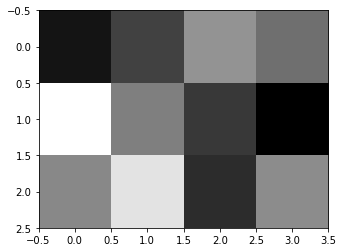

In [44]:
plt.imshow(sample_image, cmap='gray')

In [45]:
sample_deformed = extract_region(deformed_image, center, X.shape[1], X.shape[0])

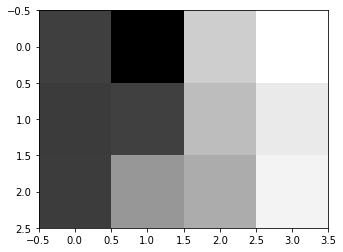

In [46]:
plt.imshow(sample_deformed, cmap='gray')

## Computing the gradient 

Let's now compute the gradient of the above image. We use the [gradient operator present in numpy](https://docs.scipy.org/doc/numpy/reference/generated/numpy.gradient.html).

In [47]:
grad = np.gradient(sample_deformed)

Let's see what it returns.

In [48]:
grad

[array([[ -2.25026554e-04,   3.77740603e-03,  -9.78620995e-04,
          -1.27087659e-03],
        [ -3.59387295e-05,   4.44735508e-03,  -9.80214707e-04,
          -3.69347864e-04],
        [  1.53149095e-04,   5.11730413e-03,  -9.81808418e-04,
           5.32180863e-04]]),
 array([[-0.0036951 ,  0.00419407,  0.0075064 ,  0.00292954],
        [ 0.00030733,  0.00381728,  0.00498226,  0.00263729],
        [ 0.00527149,  0.0032498 ,  0.00268969,  0.00415128]])]

We get two sets of arrays, the gradient along the first direction and the gradient along the second direction. Let's display this.

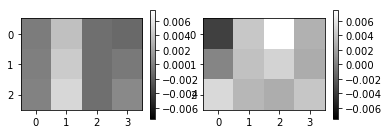

In [49]:
vmax = max(arr.max() for arr in grad)
vmin = -vmax
plt.subplot(121)
plt.imshow(grad[0], cmap='gray', vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.5)
plt.subplot(122)
plt.imshow(grad[1], cmap='gray', vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.5)

This means we now have point wise estimation of the gradient from the image. However, we want to have a continuous representation of this gradient as a weighted sum of finite elements. So in the next section we tackle this problem.

## The basis function integrals 

We want to assemble the matrix which is a function of integrals of this form: 

$$
\iint_\Omega (\vec{\nabla g} \cdot \vec{\eta_i}) (\vec{\nabla g} \cdot \vec{\eta_j}) d\Omega 
$$

This can be further broken down to a representation of this form:

$$
\iint_\Omega \eta_i \eta_j \eta_k \eta_l d\Omega 
$$

with the indices i, j, k, l denoting any of the four shape functions of the finite element basis.

So this all boils down to computing all possible integrals on the unit meshes using the four shape functions defined above.

## Assembling the M matrix 2 

Let's now take the same loop as before but let's compute the real coefficient. We double the size of the matrix since we now take the vector aspect into account. We do the computation node by node but first we use the $x$ direction, then the $y$ direction.

In [50]:
M = np.zeros((2 * len(nodes.keys()), 2 * len(nodes.keys())))

In [51]:
for current_node_id in nodes.keys():
    for current_direction in range(2):
        for other_node_id in nodes.keys():
            for other_direction in range(2):
                # compute integral
                for element_id in elements.keys():
                    all_ids = elements[element_id].all_ids()
                    # check for overlap
                    if current_node_id in all_ids and other_node_id in all_ids:
                        grad_i = grad[current_direction].ravel()[current_node_id]
                        grad_j = grad[other_direction].ravel()[current_node_id]
                        M[2 * current_node_id + current_direction, 2 * other_node_id + other_direction] = grad_i * grad_j

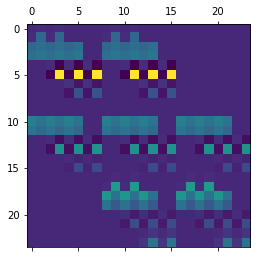

In [52]:
plt.matshow(M)

# Solution using finite differences 

## Theory 

Another way of approaching the problem is to solve it using finite differences.

The continuous equation is written as: 

$$
\vec{\nabla g} \cdot \vec{v} = g(\vec{x}) - f(\vec{x}) 
$$

We can discretize this by writing out the gradient and the displacement field $\vec{v}$ on the image grid:

$$
\nabla_x g v_x + \nabla_y g v_y = g(\vec{x}) - f(\vec{x}) 
$$

This can be written as follows in matrix form: 
$$
M V = m
$$

## Implementation 

The finite difference implementation is easier to produce than the finite element solution. Again, we start by defining our matrix M. The pointwise equation above is going to be written for each point as a vector matrix product.

The $V$ matrix is going to yield the displacement values first in $x$, then in $y$ for each node of the image mesh. 

In [53]:
M = np.zeros((len(nodes.keys()), 2 * len(nodes.keys())))

In [54]:
m = np.zeros(len(nodes.keys()))

In [55]:
grad = np.gradient(sample_deformed)

In [56]:
for current_node_id in nodes.keys():
    for current_direction in range(2):
        i, j = nodes[current_node_id]
        M[current_node_id, 2 * current_node_id + current_direction] = grad[current_direction][j, i]
        m[current_node_id] = sample_deformed[j, i] - sample_image[j, i] 

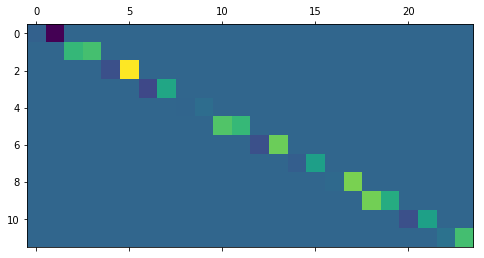

In [57]:
plt.matshow(M)

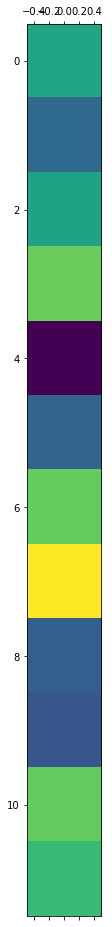

In [58]:
plt.matshow(m[:, np.newaxis])

We can now solve the problem using a linear system solver. Since the system is not square, we use a least square solver.

In [59]:
from numpy.linalg import lstsq

In [60]:
x, res, rank, s = lstsq(M, m)

In [61]:
x

array([ -3.48431510e-02,  -5.72150011e-01,  -5.52677530e-01,
        -6.13640921e-01,  -3.10605788e-02,   2.38246517e-01,
        -9.06177777e-01,   2.08886370e+00,   5.28768555e+00,
        -4.52179402e+01,  -6.58773802e-01,  -5.65442254e-01,
        -2.65885015e-01,   1.35144595e+00,  -7.05848454e-01,
         5.04003507e+00,  -3.19817830e-02,  -1.10083287e+00,
        -9.34799061e-01,  -5.93654165e-01,  -8.22501824e-01,
         2.25326901e+00,   1.38548152e-01,   1.08074518e+00])

Let's now examine the solution and recast it as an appropriate displacement field.

In [62]:
u = x[::2].reshape(X.shape)
v = x[1::2].reshape(X.shape)

In [63]:
u.shape

(3, 4)

In [64]:
v.shape

(3, 4)

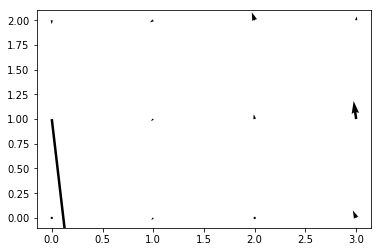

In [65]:
plt.quiver(X, Y, u, v)

Let's overlay the original image onto this.

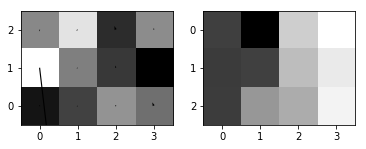

In [66]:
plt.subplot(121)
plt.imshow(sample_image, origin='lower', cmap='gray')
plt.quiver(X, Y, u, v)
plt.subplot(122)
plt.imshow(sample_deformed, cmap='gray')

This is interesting. Let's extend the resolution to the full problem.

## Full image 

In [67]:
center = (140, 100)
w, h = 70, 80

In [68]:
sample_image = extract_region(image, center, w, h)

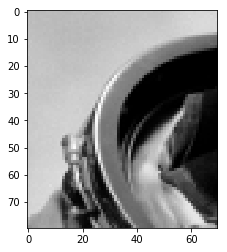

In [69]:
plt.imshow(sample_image, cmap='gray')

In [70]:
sample_deformed = extract_region(deformed_image, center, w, h)

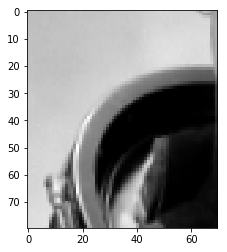

In [71]:
plt.imshow(sample_deformed, cmap='gray')

In [72]:
x = np.arange(sample_image.shape[1])
y = np.arange(sample_image.shape[0])
X, Y = np.meshgrid(x, y)

In [73]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69])

In [74]:
sample_image.shape

(80, 70)

In [75]:
nodes = {}
for i in range(X.ravel().size):
    nodes[i] = (X.ravel()[i], Y.ravel()[i])

In [76]:
len(nodes.keys())

5600

In [77]:
M = np.zeros((len(nodes.keys()), 2 * len(nodes.keys())))

In [78]:
m = np.zeros(len(nodes.keys()))

In [79]:
grad = np.gradient(sample_deformed)

Let's look at the gradient:

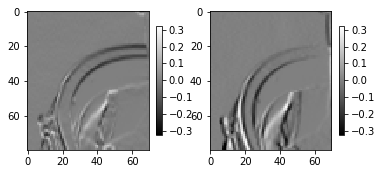

In [80]:
vmax = max(arr.max() for arr in grad)
vmin = -vmax
plt.subplot(121)
plt.imshow(grad[0], cmap='gray', vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.5)
plt.subplot(122)
plt.imshow(grad[1], cmap='gray', vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.5)

The problem here is that the gradient is zero in many regions.

In [81]:
for current_node_id in nodes.keys():
    for current_direction in range(2):
        i, j = nodes[current_node_id]
        M[current_node_id, 2 * current_node_id + current_direction] = grad[current_direction][j, i]
        m[current_node_id] = sample_deformed[j, i] - sample_image[j, i] 

In [82]:
x, res, rank, s = lstsq(M, m, rcond=0.1)

In [83]:
x

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [84]:
x.max()

18.858405608617186

In [85]:
x.min()

-20.838972303508758

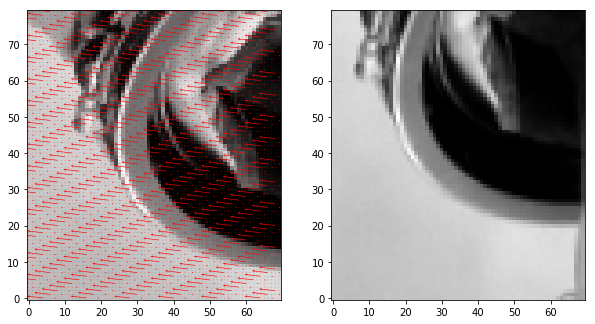

In [86]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(sample_image, origin='lower', cmap='gray')
plt.quiver(X, Y, v, u, color='red')
plt.subplot(122)
plt.imshow(sample_deformed, origin='lower', cmap='gray')

# Todo 

Actually: 

- the theory should be rewritten
- the two first branches should be explored FFT-DIC and Q4-DIC
- in theory finite difference DIC could also be explored (it would then be something between FFT-DIC and Q4-DIC)